In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from functions import *

In [2]:
def deflection(x, Mp, Fx, L):
    """
    Deflection profile of the k-fiber, given
    a moment at the pole and an axial force.
    """
    k = np.sqrt(Fx)
    y = np.sin(k*(L-x))/np.sin(k*L) - (L-x)/L
    y *= Mp/Fx
    return y

In [3]:
def find_Mp(y_target, Fx, L, Mp_min = 0, Mp_max = 1e3):
    """
    For a given axial force `Fx`, recursively finds 
    the corresponding moment at the pole Mp that yields 
    the target maximum y-deflection `y_target`.
    """
    x = np.linspace(0, L, 100)
    
    Mp_avg = 0.5*(Mp_min + Mp_max)
    y = deflection(x, Mp_avg, Fx, L)
    y_avg = y.max()
    
    if np.abs(y_avg-y_target)/y_target < 1e-3:
        return Mp_avg
    
    y = deflection(x, Mp_min, Fx, L)
    y_min = y.max()
    
    y = deflection(x, Mp_max, Fx, L)
    y_max = y.max()
    
    if y_avg > y_target:
        return find_Mp(y_target, Fx, L, Mp_min = Mp_min, Mp_max = Mp_avg)
    else:
        return find_Mp(y_target, Fx, L, Mp_min = Mp_avg, Mp_max = Mp_max)

### Fixed $y_{max}$ studies

In [4]:
L = 10 # End-to-end distance
y_target = 0.1*L # Fixed y_{max}
Fc = np.pi**2/L**2 # Critical buckling force

# Range of axial forces
Fx_ls = np.logspace(-3, -0.001, 100)*Fc

# Corresponding moments at the pole
Mp_ls = np.zeros_like(Fx_ls)

# Corresponding x-positions of the peak
x_peak_ls = np.zeros_like(Fx_ls)

# List of x-coordinates to find x_{peak}
x = np.linspace(0, L, 10000)

for i in range(len(Fx_ls)):
    Fx = Fx_ls[i]
    Mp_ls[i] = find_Mp(y_target, Fx, L)
    
    y = deflection(x, Mp_ls[i], Fx, L)
    x_peak = x[np.where(y==y.max())[0][0]]
    x_peak_ls[i] = x_peak

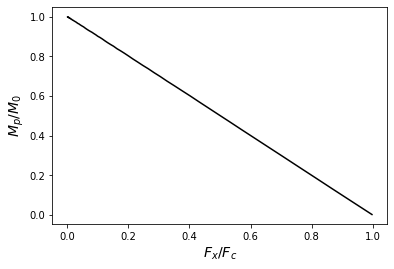

In [5]:
plt.plot(Fx_ls/Fc, Mp_ls/Mp_ls[0], color='k')
plt.xlabel(r'$F_x/F_c$', fontsize=14)
plt.ylabel(r'$M_p/M_0$', fontsize=14)
plt.savefig('Mp_Fx_dependence.eps')
plt.show()

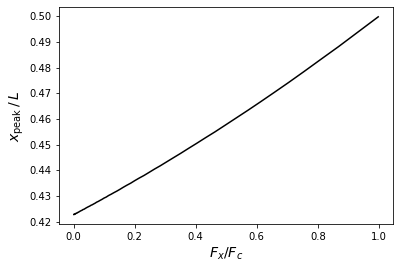

In [6]:
plt.plot(Fx_ls/Fc, x_peak_ls/L, color='k')
plt.xlabel(r'$F_x/F_c$', fontsize=14)
plt.ylabel(r'$x_{\rm peak}\,/\,L$', fontsize=14)
plt.savefig('xpeak_Fx_dependence.eps')
plt.show()

### $L$-dependence studies

In [7]:
def give_L(Mp, Fx, Lc, Lmin, Lmax):
    """
    Gives the k-fiber's end-to-end distance L corresponding
    to the specified contour length Lc when the k-fiber
    is deflected under the influence of forces Mp and Fx.
    """
    x = np.linspace(0, Lmin, 100)
    y = deflection(x, Mp, Fx, Lmin)
    _, Lc_min = contour_fn(x,y)
    
    x = np.linspace(0, Lmax, 100)
    y = deflection(x, Mp, Fx, Lmax)
    _, Lc_max = contour_fn(x,y)
    
    L_avg = 0.5*(Lmin + Lmax)
    x = np.linspace(0, L_avg, 100)
    y = deflection(x, Mp, Fx, L_avg)
    _, Lc_avg = contour_fn(x,y)
    
    if np.abs(Lc - Lc_avg)/Lc < 1e-3:
        return L_avg
    
    if Lc_avg < Lc:
        return give_L(Mp, Fx, Lc, L_avg, Lmax)
    else:
        return give_L(Mp, Fx, Lc, Lmin, L_avg)

In [8]:
Mp = 0.114
Mp_sem = 0.00977

Fx = 0.084
Fx_sem = 0.0134

d_PP = 16.27
d_PP_sem = 0.778

Lc_over_PP_ls = [0.36121701006337253, 0.4092583918713443, 0.4467934504154682, 0.45914101430336823]
Lc_over_PP_sem_ls = [0.014627642401244093, 0.02310415119074849, 0.010695719226981289, 0.019395623329532832]

ymax_norm_ls = []
bin_ls = []
L_ls = []
for i in range(len(Lc_over_PP_ls)):
    
    for _ in range(200):
        
        d_PPP = d_PP + np.random.normal(0, d_PP_sem)
        Lc_over_PPP = Lc_over_PP_ls[i] + np.random.normal(0, Lc_over_PP_sem_ls[i])
        Lcc = Lc_over_PPP * d_PPP
        Mpp = Mp + np.random.normal(0, Mp_sem)
        Fxx = Fx + np.random.normal(0, Fx_sem)
        
        L = give_L(Mpp, Fxx, Lcc, 0.5*Lcc, Lcc)

        x = np.linspace(0, L, 100)
        y = deflection(x, Mpp, Fxx, L)

        ymax_norm_ls.append(max(y)/L)
        bin_ls.append(i)
        L_ls.append(L)
        
L_ls = np.array(L_ls)
ymax_norm_ls = np.array(ymax_norm_ls)
bin_ls = np.array(bin_ls)

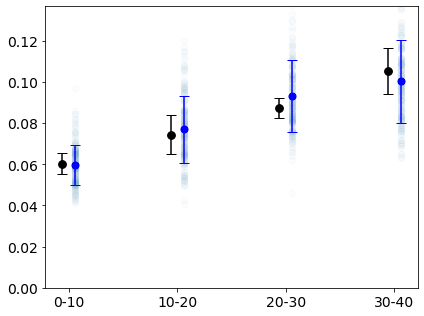

In [9]:
plt.figure(figsize=(6,4.5))

bins = [0, 1, 2, 3]
data = [0.06028212, 0.07429598, 0.08728503, 0.10509759]
data_sem = [0.00508414, 0.00956137, 0.00496703, 0.0111602]

plt.scatter([0.06 + b for b in bin_ls], ymax_norm_ls, 40, alpha=0.02)
plt.scatter([b - 0.06 for b in bins], data, 60, color='k')
plt.errorbar([b - 0.06 for b in bins], data, yerr=data_sem, color='k', fmt='o', capsize=5)

for b in bins:
    y_set = ymax_norm_ls[bin_ls == b]
    plt.scatter(b+0.06, np.mean(y_set), 50, color='b')
    plt.errorbar(b+0.06, np.mean(y_set), yerr = np.std(y_set), color='b', fmt='o-', capsize=5)

# plt.xlabel('Angle bin (°)', fontsize=14)
# plt.ylabel(r'Largest y-deflection, $y_{\rm max}/L$', fontsize=14)
plt.xticks([0, 1, 2, 3], ['0-10', '10-20', '20-30', '30-40'], fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([0, 1.3*max(data)])
plt.tight_layout()

plt.savefig('y_max_trends.pdf')
plt.show()